In [1]:
%matplotlib inline
import rubin_sim.skybrightness as sb
import rubin_sim.photUtils.Bandpass as Bandpass
import numpy as np
import matplotlib.pylab as plt
import healpy as hp


from rubin_sim.skybrightness.utils import robustRMS, ut2Mjd, mjd2ut
from rubin_sim.utils import (_altAzPaFromRaDec, haversine, calcLmstLast, _raDecFromAltAz,
 Site, ObservationMetaData, _healbin, _approx_RaDec2AltAz)


In [2]:
sm = sb.SkyModel(twilight=False, zodiacal=False, moon=False)

In [3]:
# Pretty sure this should set it to zenith
sm.setRaDecMjd(0., 90., 58000, azAlt=True, degrees=True)


In [4]:
# Double check that we're at zenith, looks good, internals are in radians.
sm.alts, sm.azs

(array([1.57079633]), array([0.]))

In [5]:
# zomg, I'm a horrible person who failed to document output units. I'll go fix that. wave is in nm, and spec is flambda in ergs/cm^2/s/nm
wave, spec = sm.returnWaveSpec()

Text(0, 0.5, 'ergs/cm^2/s/nm')

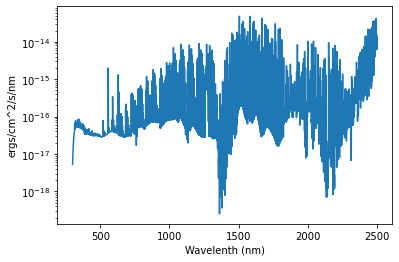

In [6]:
plt.semilogy(wave, spec[0,:])
plt.xlabel('Wavelenth (nm)')
plt.ylabel('ergs/cm^2/s/nm')

In [7]:
sm = sb.SkyModel(observatory='LSST', lowerAtm=True, upperAtm=True, airglow=True, scatteredStar=True, mergedSpec=True)
sm.mergedSpec = False

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness/skyModel.py:129: UserWarning: Adding component multiple times to the final output spectra.
  warnings.warn("Adding component multiple times to the final output spectra.")


In [8]:
sm.setRaDecMjd(np.array([36.]),np.array([-68.]),49353.177645, degrees=True)

(1e-17, 1e-14)

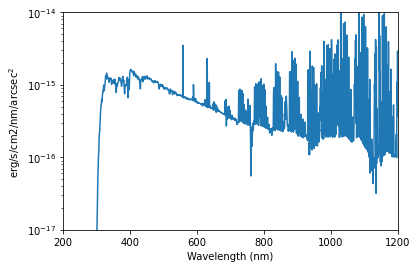

In [9]:
plt.semilogy(sm.wave, sm.spec[0])
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.xlim([200,1200])
plt.ylim([1e-17,1e-14])

In [10]:
nside=32
hpmap = np.zeros(hp.nside2npix(nside))
lat, ra = hp.pix2ang(nside, np.arange(hpmap.size))
dec = np.pi/2-lat
telescope = Site('LSST')

In [11]:
sm = sb.SkyModel(observatory='LSST', mags=True)
mjd = 49353.177645
sm.setRaDecMjd(ra,dec,mjd)
mag = sm.returnMags()
lmst, last = calcLmstLast(mjd,telescope.longitude_rad)

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the 

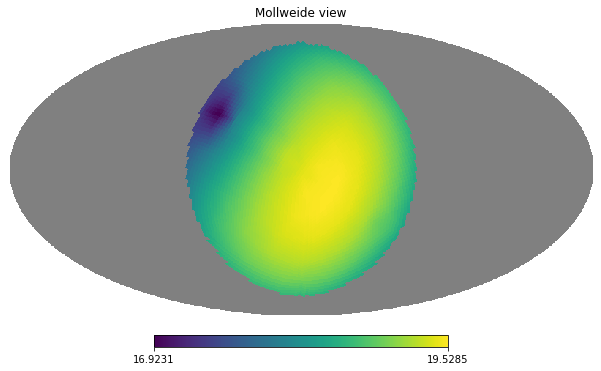

In [12]:
hp.mollview(mag['g'], rot=(lmst*180./12, np.degrees(telescope.latitude_rad)))

In [13]:
moonRA, moonDec =  _approx_RaDec2AltAz(np.array([sm.moonAlt]),np.array([sm.moonAz]),
                                             telescope.latitude_rad,telescope.longitude_rad,mjd)# _raDecFromAltAz(sm.moonAlt, sm.moonAz, ObservationMetaData(mjd=mjd,site=telescope))


In [14]:
alt,az =  _approx_RaDec2AltAz(ra, dec,
                                    telescope.latitude_rad,telescope.longitude_rad,mjd)  

angDist2Moon = np.degrees(haversine(az,alt, sm.moonAz,sm.moonAlt))
ang2 = np.degrees(haversine(ra,dec, moonRA[0],moonDec[0]))
alt = np.degrees(alt)

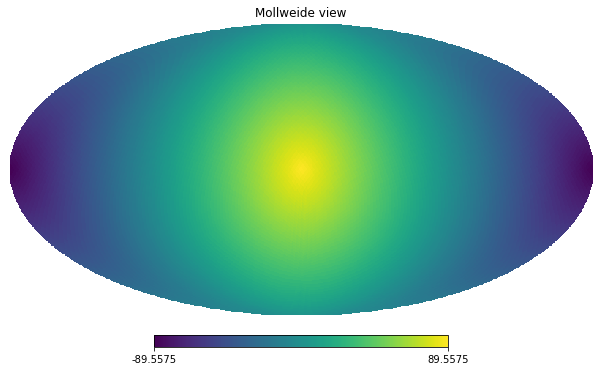

In [15]:
hp.mollview(alt, rot=(lmst*180./12, np.degrees(telescope.latitude_rad)))

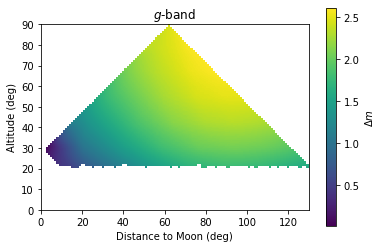

In [16]:
from scipy.interpolate import griddata

mags = mag['g']-np.nanmin(mag['g'])

extent = (0,130, 0,90)
xs,ys = np.mgrid[extent[0]:extent[1], extent[2]:extent[3]]
resampled = griddata((angDist2Moon, alt), mags, (xs, ys))
blah=plt.imshow(resampled.T, extent=extent, origin='lower')
#blah = plt.hexbin(angDist2Moon, alt, mags)
cb = plt.colorbar(blah)
plt.xlabel('Distance to Moon (deg)')
plt.ylabel('Altitude (deg)')
plt.title('$g$-band')
cb.set_label('$\Delta m$')



